In [131]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import datetime
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

## Read in flarelist

In [132]:
## read in flarelist
flare_list = pd.read_csv("/Users/laurahayes/ml_project_flares/flare_analysis/goes_flare_list/final_flare_list.csv")
# create a column "matchtime" which will be used to merge with the AR data
flare_list["matchtime"] = pd.to_datetime(flare_list["event_starttime"], format="%Y-%m-%d %H:%M:%S").dt.strftime("%Y-%m-%d 00:30")

# tidying up some other columns (i.e. make AR num a string, and sort out dates of start, peak and end of flare)
flare_list["noaa_ar"] = flare_list["noaa_ar"].astype(str)


In [133]:
test_df = flare_list[(flare_list["event_starttime"]>="2016-01-01")&(flare_list["event_starttime"]<="2017-12-31")]

In [134]:
len(test_df["matchtime"].unique())

188

In [135]:
len(test_df[test_df["noaa_ar"]!="     "]["matchtime"].unique())

176

In [136]:
len(test_df[test_df["goes_class_ind"].isin(["M", "X"])]["matchtime"].unique())

26

In [137]:
flare_list2 = flare_list[["matchtime", "noaa_ar", "goes_class_ind"]]
flare_list2 = flare_list2[flare_list2["noaa_ar"] != "     "]
flare_list2.reset_index(inplace=True, drop=True)

In [138]:
flare_list2

,matchtime,noaa_ar,goes_class_ind
0,2010-01-02 00:30,11039,C
1,2010-01-02 00:30,11039,C
2,2010-01-03 00:30,11039,C
3,2010-01-04 00:30,11039,C
4,2010-01-09 00:30,11040,C
...,...,...,...
7664,2018-03-30 00:30,12703,C
7665,2018-05-23 00:30,12712,C
7666,2018-05-28 00:30,12712,C
7667,2018-06-06 00:30,12712,C


In [139]:
flare_inds = pd.get_dummies(flare_list2["goes_class_ind"])
flare_list2 = flare_list2.merge(flare_inds, left_index=True, right_index=True)#.drop(columns="goes_class_ind")

In [140]:
flare_list2

,matchtime,noaa_ar,goes_class_ind,C,M,X
0,2010-01-02 00:30,11039,C,1,0,0
1,2010-01-02 00:30,11039,C,1,0,0
2,2010-01-03 00:30,11039,C,1,0,0
3,2010-01-04 00:30,11039,C,1,0,0
4,2010-01-09 00:30,11040,C,1,0,0
...,...,...,...,...,...,...
7664,2018-03-30 00:30,12703,C,1,0,0
7665,2018-05-23 00:30,12712,C,1,0,0
7666,2018-05-28 00:30,12712,C,1,0,0
7667,2018-06-06 00:30,12712,C,1,0,0


In [141]:
final_2 = flare_list2.groupby(["matchtime", "noaa_ar"]).sum().reset_index()

In [142]:
final_2

,matchtime,noaa_ar,C,M,X
0,2010-01-02 00:30,11039,2,0,0
1,2010-01-03 00:30,11039,1,0,0
2,2010-01-04 00:30,11039,1,0,0
3,2010-01-09 00:30,11040,1,0,0
4,2010-01-12 00:30,11040,1,0,0
...,...,...,...,...,...
3041,2018-03-30 00:30,12703,1,0,0
3042,2018-05-23 00:30,12712,1,0,0
3043,2018-05-28 00:30,12712,1,0,0
3044,2018-06-06 00:30,12712,1,0,0


In [143]:
final_2["C+"] = final_2["C"] + final_2["M"] + final_2["X"]
final_2["M+"] = final_2["M"] + final_2["X"]
final_2["X+"] = final_2["X"]

In [144]:
final_2.drop(columns=["C", "M", "X"], inplace=True)

In [145]:
final_2

,matchtime,noaa_ar,C+,M+,X+
0,2010-01-02 00:30,11039,2,0,0
1,2010-01-03 00:30,11039,1,0,0
2,2010-01-04 00:30,11039,1,0,0
3,2010-01-09 00:30,11040,1,0,0
4,2010-01-12 00:30,11040,1,0,0
...,...,...,...,...,...
3041,2018-03-30 00:30,12703,1,0,0
3042,2018-05-23 00:30,12712,1,0,0
3043,2018-05-28 00:30,12712,1,0,0
3044,2018-06-06 00:30,12712,1,0,0


In [146]:
len(final_2)

3046

## Read in AR list

In [261]:
# read in active region list
ar_data = pd.read_csv("/Users/laurahayes/ml_project_flares/flare_analysis/AR_analysis/SRS_all_2010-2018.csv")
# pull out only the data of interest (i.e. regions with sunspots marked with ID="I" from SRS)
ar_data = ar_data[ar_data["ID"].isin(["I"])]#, "II"])]
# similarly create a "matchtime" columns
ar_data["matchtime"] = ar_data["date"]
# rename AR column so that it can be merged with GOES flare list
ar_data["noaa_ar"] = ar_data["Number"].astype(str)
ar_data.rename(columns={"date":"AR issue_date"}, inplace=True)


In [262]:
len(ar_data)

11885

In [263]:
merged_db = pd.merge(ar_data, final_2, how="left", on=["matchtime", "noaa_ar"])
merged_db.reset_index(inplace=True, drop=True)

In [264]:
len(merged_db)

11885

In [265]:
len(merged_db[merged_db["C+"].notnull()])

2517

In [266]:
merged_db["C+"].notnull().sum()/len(merged_db)

0.21177955405973917

In [267]:
merged_db["flare"] = merged_db["C+"].map(lambda x: 1 if x>0 else 0)

In [268]:
merged_db.head()

,ID,Number,Carrington Longitude,Area,Z,Longitudinal Extent,Number of Sunspots,Mag Type,Latitude,Longitude,AR issue_date,matchtime,noaa_ar,C+,M+,X+,flare
0,I,11039,54.0,130.0,Dai,6.0,8.0,Beta,-28.0,21.0,2010-01-01 00:30,2010-01-01 00:30,11039,NaN,NaN,NaN,0
1,I,11039,54.0,120.0,Dso,9.0,6.0,Beta,-27.0,35.0,2010-01-02 00:30,2010-01-02 00:30,11039,2.0,0.0,0.0,1
2,I,11039,52.0,190.0,Dso,8.0,12.0,Beta,-28.0,46.0,2010-01-03 00:30,2010-01-03 00:30,11039,1.0,0.0,0.0,1
3,I,11039,52.0,220.0,Dso,7.0,10.0,Beta,-29.0,59.0,2010-01-04 00:30,2010-01-04 00:30,11039,1.0,0.0,0.0,1
4,I,11039,52.0,150.0,Dso,7.0,5.0,Beta,-28.0,72.0,2010-01-05 00:30,2010-01-05 00:30,11039,NaN,NaN,NaN,0


## Lets try get a column that says if there was a flare the day previously on that AR

In [269]:
merged_db[["matchtime", "noaa_ar"]].iloc[10]

matchtime    2010-01-12 00:30
noaa_ar                 11040
Name: 10, dtype: object

In [270]:
if np.isnan(merged_db.iloc[10]["C+"]) is False:
    print("helo")

In [157]:
# i = 1
# test = merged_db.iloc[i]
# previous_day = (pd.to_datetime(test["matchtime"])-datetime.timedelta(days=1)).strftime("%Y-%m-%d 00:30")
# ar_match = test["noaa_ar"]
# data_prev = merged_db[(merged_db["matchtime"].isin([previous_day]))&(merged_db["noaa_ar"].isin([ar_match]))]


In [158]:
data_prev["Z"].values[0]

'Dai'

In [159]:
if not np.isnan(data_prev["C+"].values):
    print("hello")

In [160]:
def get_prev(i):
    test = merged_db.iloc[i]
    previous_day = (pd.to_datetime(test["matchtime"])-datetime.timedelta(days=1)).strftime("%Y-%m-%d 00:30")
    ar_match = test["noaa_ar"]
    data_prev = merged_db[(merged_db["matchtime"].isin([previous_day]))&(merged_db["noaa_ar"].isin([ar_match]))]
#     if len(data_prev)==1:
#         if not np.isnan(data_prev["no_flares"].values):
#             return data_prev["no_flares"].values[0]
#         else:
#             return 0
#     else
#         return 0
    return data_prev



In [181]:
get_prev(0)[["Z", "flare"]]

Series([], Name: Z, dtype: object)

In [165]:
# previous = [get_prev(i)[["Z", "flare"]] for i in range(len(merged_db))]

In [167]:
# merged_db["previous_day_flare"] = previous

In [271]:
# previous[1]["Z"].values[0]

In [272]:
merged_db.tail()

,ID,Number,Carrington Longitude,Area,Z,Longitudinal Extent,Number of Sunspots,Mag Type,Latitude,Longitude,AR issue_date,matchtime,noaa_ar,C+,M+,X+,flare
11880,I,12729,231.0,10.0,Bxo,6.0,2.0,Beta,-5.0,80.0,2018-12-09 00:30,2018-12-09 00:30,12729,NaN,NaN,NaN,0
11881,I,12729,231.0,10.0,Bxo,6.0,2.0,Beta,-5.0,93.0,2018-12-10 00:30,2018-12-10 00:30,12729,NaN,NaN,NaN,0
11882,I,12730,94.0,10.0,Axx,2.0,1.0,Alpha,8.0,-17.0,2018-12-12 00:30,2018-12-12 00:30,12730,NaN,NaN,NaN,0
11883,I,12731,23.0,10.0,Bxo,5.0,2.0,Beta,13.0,-49.0,2018-12-15 00:30,2018-12-15 00:30,12731,NaN,NaN,NaN,0
11884,I,12731,24.0,10.0,Axx,1.0,2.0,Alpha,13.0,-35.0,2018-12-16 00:30,2018-12-16 00:30,12731,NaN,NaN,NaN,0


In [284]:
merged_db[["C+", "M+", "X+"]] = merged_db[["C+", "M+", "X+"]].fillna(0)

In [285]:
merged_db["zurich"] = merged_db["Z"].map(lambda x: x[0])
merged_db["penumbral"] = merged_db["Z"].map(lambda x: x[1])
merged_db["compact"] = merged_db["Z"].map(lambda x: x[2])


In [286]:
merged_db["compact"].unique()

array(['i', 'o', 'c', 'x'], dtype=object)

In [287]:
merged_db[["zurich", "noaa_ar", "matchtime"]]

,zurich,noaa_ar,matchtime
0,D,11039,2010-01-01 00:30
1,D,11039,2010-01-02 00:30
2,D,11039,2010-01-03 00:30
3,D,11039,2010-01-04 00:30
4,D,11039,2010-01-05 00:30
...,...,...,...
11880,B,12729,2018-12-09 00:30
11881,B,12729,2018-12-10 00:30
11882,A,12730,2018-12-12 00:30
11883,B,12731,2018-12-15 00:30


In [288]:
len(merged_db["noaa_ar"].unique())

1689

In [289]:
merged_db.head()

,ID,Number,Carrington Longitude,Area,Z,Longitudinal Extent,Number of Sunspots,Mag Type,Latitude,Longitude,AR issue_date,matchtime,noaa_ar,C+,M+,X+,flare,zurich,penumbral,compact
0,I,11039,54.0,130.0,Dai,6.0,8.0,Beta,-28.0,21.0,2010-01-01 00:30,2010-01-01 00:30,11039,0.0,0.0,0.0,0,D,a,i
1,I,11039,54.0,120.0,Dso,9.0,6.0,Beta,-27.0,35.0,2010-01-02 00:30,2010-01-02 00:30,11039,2.0,0.0,0.0,1,D,s,o
2,I,11039,52.0,190.0,Dso,8.0,12.0,Beta,-28.0,46.0,2010-01-03 00:30,2010-01-03 00:30,11039,1.0,0.0,0.0,1,D,s,o
3,I,11039,52.0,220.0,Dso,7.0,10.0,Beta,-29.0,59.0,2010-01-04 00:30,2010-01-04 00:30,11039,1.0,0.0,0.0,1,D,s,o
4,I,11039,52.0,150.0,Dso,7.0,5.0,Beta,-28.0,72.0,2010-01-05 00:30,2010-01-05 00:30,11039,0.0,0.0,0.0,0,D,s,o


## Lets build a first simple ML model

In [290]:
first_db = merged_db.drop(columns=["ID", "Number", "Carrington Longitude", "Latitude", "Longitude", 
                                  "AR issue_date", "noaa_ar",
                                   "zurich", "penumbral", "compact"])

In [291]:
first_db

,Area,Z,Longitudinal Extent,Number of Sunspots,Mag Type,matchtime,C+,M+,X+,flare
0,130.0,Dai,6.0,8.0,Beta,2010-01-01 00:30,0.0,0.0,0.0,0
1,120.0,Dso,9.0,6.0,Beta,2010-01-02 00:30,2.0,0.0,0.0,1
2,190.0,Dso,8.0,12.0,Beta,2010-01-03 00:30,1.0,0.0,0.0,1
3,220.0,Dso,7.0,10.0,Beta,2010-01-04 00:30,1.0,0.0,0.0,1
4,150.0,Dso,7.0,5.0,Beta,2010-01-05 00:30,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...
11880,10.0,Bxo,6.0,2.0,Beta,2018-12-09 00:30,0.0,0.0,0.0,0
11881,10.0,Bxo,6.0,2.0,Beta,2018-12-10 00:30,0.0,0.0,0.0,0
11882,10.0,Axx,2.0,1.0,Alpha,2018-12-12 00:30,0.0,0.0,0.0,0
11883,10.0,Bxo,5.0,2.0,Beta,2018-12-15 00:30,0.0,0.0,0.0,0


In [292]:
100*first_db["flare"].value_counts()/len(first_db)

0    78.822045
1    21.177955
Name: flare, dtype: float64

In [293]:
first_db.head()

,Area,Z,Longitudinal Extent,Number of Sunspots,Mag Type,matchtime,C+,M+,X+,flare
0,130.0,Dai,6.0,8.0,Beta,2010-01-01 00:30,0.0,0.0,0.0,0
1,120.0,Dso,9.0,6.0,Beta,2010-01-02 00:30,2.0,0.0,0.0,1
2,190.0,Dso,8.0,12.0,Beta,2010-01-03 00:30,1.0,0.0,0.0,1
3,220.0,Dso,7.0,10.0,Beta,2010-01-04 00:30,1.0,0.0,0.0,1
4,150.0,Dso,7.0,5.0,Beta,2010-01-05 00:30,0.0,0.0,0.0,0


In [294]:
list(first_db["Z"].iloc[0])

['D', 'a', 'i']

In [295]:
# first_db["zurich"] = first_db["Z"].map(lambda x: x[0])
# first_db["penumbral"] = first_db["Z"].map(lambda x: x[1])
# first_db["compact"] = first_db["Z"].map(lambda x: x[2])
# first_db.drop(columns="Z", inplace=True)

In [296]:
# first_db["penumbral"].unique()

In [297]:
# first_db["zurich"].unique()

In [298]:
# first_db["compact"].unique()

In [299]:
# print(first_db[first_db["flare"]==1]["zurich"].value_counts())
# print(first_db[first_db["flare"]==0]["zurich"].value_counts())

In [300]:
first_db.head()

,Area,Z,Longitudinal Extent,Number of Sunspots,Mag Type,matchtime,C+,M+,X+,flare
0,130.0,Dai,6.0,8.0,Beta,2010-01-01 00:30,0.0,0.0,0.0,0
1,120.0,Dso,9.0,6.0,Beta,2010-01-02 00:30,2.0,0.0,0.0,1
2,190.0,Dso,8.0,12.0,Beta,2010-01-03 00:30,1.0,0.0,0.0,1
3,220.0,Dso,7.0,10.0,Beta,2010-01-04 00:30,1.0,0.0,0.0,1
4,150.0,Dso,7.0,5.0,Beta,2010-01-05 00:30,0.0,0.0,0.0,0


Encode the Hale Classes

In [301]:
# encode hale
hale_encode = pd.get_dummies(first_db["Mag Type"])
first_db = first_db.merge(hale_encode, left_index=True, right_index=True).drop(columns="Mag Type")

In [302]:
first_db.tail()

,Area,Z,Longitudinal Extent,Number of Sunspots,matchtime,C+,M+,X+,flare,Alpha,Beta,Beta-Delta,Beta-Gamma,Beta-Gamma-Delta
11880,10.0,Bxo,6.0,2.0,2018-12-09 00:30,0.0,0.0,0.0,0,0,1,0,0,0
11881,10.0,Bxo,6.0,2.0,2018-12-10 00:30,0.0,0.0,0.0,0,0,1,0,0,0
11882,10.0,Axx,2.0,1.0,2018-12-12 00:30,0.0,0.0,0.0,0,1,0,0,0,0
11883,10.0,Bxo,5.0,2.0,2018-12-15 00:30,0.0,0.0,0.0,0,0,1,0,0,0
11884,10.0,Axx,1.0,2.0,2018-12-16 00:30,0.0,0.0,0.0,0,1,0,0,0,0


In [303]:
# encode mcintosh
hale_encode = pd.get_dummies(first_db["Z"])
first_db = first_db.merge(hale_encode, left_index=True, right_index=True).drop(columns="Z")

In [304]:
# encode mcintosh - this will need to be fixed
# hale_encode = pd.get_dummies(first_db["zurich"])
# first_db = first_db.merge(hale_encode, left_index=True, right_index=True).drop(columns="zurich")

# hale_encode2 = pd.get_dummies(first_db["penumbral"])
# first_db = first_db.merge(hale_encode2, left_index=True, right_index=True).drop(columns="penumbral")

# hale_encode3 = pd.get_dummies(first_db["compact"])
# first_db = first_db.merge(hale_encode3, left_index=True, right_index=True).drop(columns="compact")

In [305]:
first_db

,Area,Longitudinal Extent,Number of Sunspots,matchtime,C+,M+,X+,flare,Alpha,Beta,...,Fko,Fsc,Fsi,Fso,Hax,Hhx,Hkx,Hrx,Hso,Hsx
0,130.0,6.0,8.0,2010-01-01 00:30,0.0,0.0,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,120.0,9.0,6.0,2010-01-02 00:30,2.0,0.0,0.0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,190.0,8.0,12.0,2010-01-03 00:30,1.0,0.0,0.0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,220.0,7.0,10.0,2010-01-04 00:30,1.0,0.0,0.0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,150.0,7.0,5.0,2010-01-05 00:30,0.0,0.0,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11880,10.0,6.0,2.0,2018-12-09 00:30,0.0,0.0,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
11881,10.0,6.0,2.0,2018-12-10 00:30,0.0,0.0,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
11882,10.0,2.0,1.0,2018-12-12 00:30,0.0,0.0,0.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
11883,10.0,5.0,2.0,2018-12-15 00:30,0.0,0.0,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [306]:
first_db["matchtime"] = pd.to_datetime(first_db["matchtime"])

In [307]:
test_db = first_db[(first_db["matchtime"]>"2016-01-01")&(first_db["matchtime"]<"2017-12-31")]
train_db = first_db[~(first_db["matchtime"]>"2016-01-01")&(first_db["matchtime"]<"2017-12-31")]

In [308]:
print(len(test_db), len(train_db), 100*len(test_db)/len(first_db), 100*len(train_db)/len(first_db))
print(np.sum(test_db["flare"]), np.sum(test_db["flare"])/np.sum(first_db["flare"]))

1388 10332 11.678586453512832 86.93310896087505
169 0.06714342471195868


In [309]:
first_db

,Area,Longitudinal Extent,Number of Sunspots,matchtime,C+,M+,X+,flare,Alpha,Beta,...,Fko,Fsc,Fsi,Fso,Hax,Hhx,Hkx,Hrx,Hso,Hsx
0,130.0,6.0,8.0,2010-01-01 00:30:00,0.0,0.0,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,120.0,9.0,6.0,2010-01-02 00:30:00,2.0,0.0,0.0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,190.0,8.0,12.0,2010-01-03 00:30:00,1.0,0.0,0.0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,220.0,7.0,10.0,2010-01-04 00:30:00,1.0,0.0,0.0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,150.0,7.0,5.0,2010-01-05 00:30:00,0.0,0.0,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11880,10.0,6.0,2.0,2018-12-09 00:30:00,0.0,0.0,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
11881,10.0,6.0,2.0,2018-12-10 00:30:00,0.0,0.0,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
11882,10.0,2.0,1.0,2018-12-12 00:30:00,0.0,0.0,0.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
11883,10.0,5.0,2.0,2018-12-15 00:30:00,0.0,0.0,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## First pass - dont split that way

In [312]:
first_db["C+"] = first_db["C+"].map(lambda x: 1 if x>0 else 0)
first_db["M+"] = first_db["M+"].map(lambda x: 1 if x>0 else 0)
first_db["X+"] = first_db["X+"].map(lambda x: 1 if x>0 else 0)

In [403]:
features = first_db.drop(columns=["matchtime", "flare", "C+", "M+", "X+"])
labels = first_db["flare"]

In [404]:
labels.unique()

array([0, 1])

In [405]:
labels.head()

0    0
1    1
2    1
3    1
4    0
Name: flare, dtype: int64

In [406]:
features.head()

,Area,Longitudinal Extent,Number of Sunspots,Alpha,Beta,Beta-Delta,Beta-Gamma,Beta-Gamma-Delta,Axx,Bxi,...,Fko,Fsc,Fsi,Fso,Hax,Hhx,Hkx,Hrx,Hso,Hsx
0,130.0,6.0,8.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,120.0,9.0,6.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,190.0,8.0,12.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,220.0,7.0,10.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,150.0,7.0,5.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [407]:
print(len(features.columns))

67


Lets now split this data to train and test (80/20%). First off lets shuffle

In [430]:
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.1, shuffle=True)

In [431]:
print(np.sum(Y_train)/len(Y_train), np.sum(Y_test)/len(Y_test))

0.21204188481675393 0.2094196804037006


In [432]:
mdl = GradientBoostingClassifier()
mdl.fit(X_train, Y_train)

GradientBoostingClassifier()

In [433]:
prediction = mdl.predict(X_test)

In [386]:
probs = mdl.predict_proba(X_test)

In [387]:
from sklearn.metrics import roc_curve, auc

In [389]:
fpr, tpr, thresholds = roc_curve(Y_test, probs[:, 1])
auc_roc = auc(fpr, tpr)

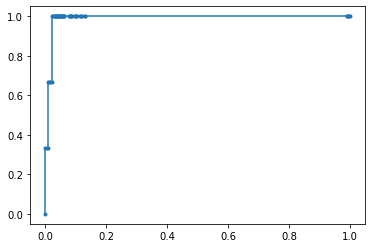

In [391]:
plt.plot(fpr, tpr, marker='.')

In [393]:
mdl.score(X_test, Y_test)

0.9974768713204374

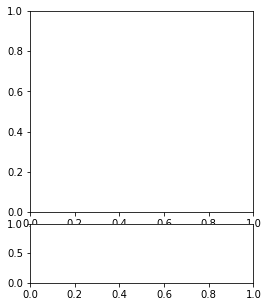

In [396]:
fig_rel = plt.figure(figsize=(4,5))
ax_rel = plt.subplot2grid((4, 1), (0, 0), rowspan=3)

ax_sharp = plt.subplot2grid((4, 1), (3, 0))


In [371]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [372]:
CM = confusion_matrix(Y_test, prediction)

In [373]:
CM = confusion_matrix(Y_test, prediction)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]

def get_tss(tp, fp, tn, fn):
    return (tp/(tp+fn)) - (fp/(fp+tn))

tss = get_tss(TP, FP, TN, FN)
tss

0.3324901630129286

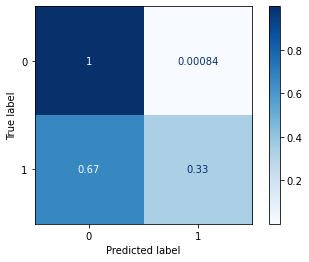

In [374]:
plot_confusion_matrix(mdl, X_test, Y_test, cmap=plt.cm.Blues,
                                 normalize='true')

In [434]:
from sklearn import svm

In [435]:
clf = svm.SVC(class_weight="balanced")
clf.fit(X_train, Y_train)

SVC(class_weight='balanced')

In [436]:
pred = clf.predict(X_test)

In [437]:
np.sum(pred)

336

In [438]:
np.sum(Y_test)

249

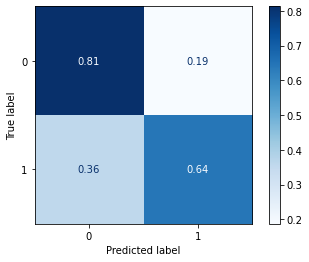

In [439]:
plot_confusion_matrix(clf, X_test, Y_test, cmap=plt.cm.Blues, normalize='true')

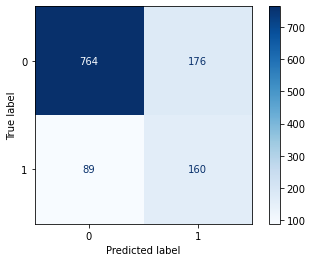

In [440]:
plot_confusion_matrix(clf, X_test, Y_test, cmap=plt.cm.Blues)

In [441]:
CM = confusion_matrix(Y_test, pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]

def get_tss(tp, fp, tn, fn):
    return (tp/(tp+fn)) - (fp/(fp+tn))

tss = get_tss(TP, FP, TN, FN)
tss

0.4553362385713065

In [99]:
tss = get_tss(TP, FP, TN, FN)
tss

0.30399434429126904

In [97]:
def plot_feature_importance(mdl, features, top=-1, title="Feature importance"):
    """
    Function to plot the importance of features from a model. 
    
    Parameters
    ----------
    mdl : sklearn model that has been already fit
    features : `pd.DataFrame` of features. 
    top : `int`, optional, number of top features to plot.
          default is to plot all. 
    
    """
    feature_importance = mdl.feature_importances_
    
    sorted_idx = np.argsort(feature_importance)[::-1][0:top]
    np.array(features.columns)[sorted_idx]
    
    pos = np.arange(0, sorted_idx.shape[0]*2, 2)
    
    fig = plt.figure(figsize=(10, 8))
    plt.barh(pos, feature_importance[sorted_idx], 2, align='center')
    plt.gca().invert_yaxis()
    plt.yticks(pos, np.array(features.columns)[sorted_idx])
    plt.title(title)

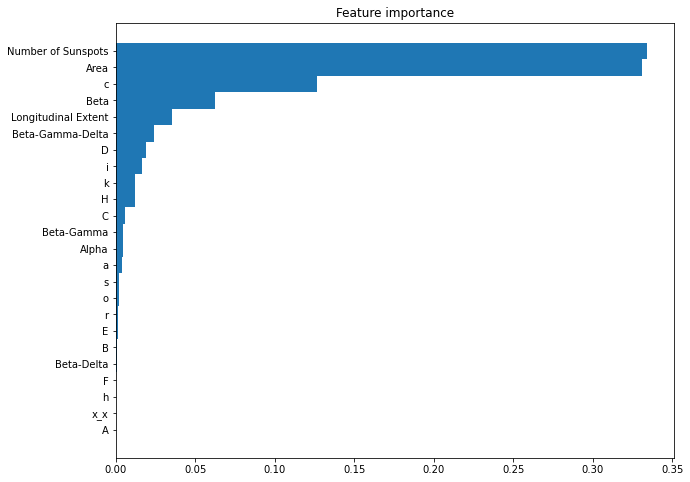

In [98]:
plot_feature_importance(mdl, features)

In [442]:
from sklearn import svm, datasets

In [444]:
iris = datasets.load_iris()
#Store variables as target y and the first two features as X (sepal length and sepal width of the iris flowers)
X = iris.data[:, :2]
y = iris.target


In [445]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])